In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from openai import OpenAI
from tqdm import tqdm
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

/data/mn27889/miniconda3/envs/mental-health/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get the CounselChat Dataset

In [4]:
dataset_name = "nbertagnolli/counsel-chat"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=42)

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
dataset_df = dataset.to_pandas()
dataset_df.head()

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,569,How do you get over someone cheating on you wh...,My boyfriend of five years told me he cheated ...,https://counselchat.com/questions/how-do-you-g...,intimacy,"Lynda MartensMarriage & Family Therapist, MSc,...",https://counselchat.com/therapists/ms-lynda-ma...,"Hi Michigan,This is a common issue. How do you...",2,130
1,787,Is it acceptable for me to find another home f...,My boyfriend moved in with me a few months ago...,https://counselchat.com/questions/is-it-accept...,relationships,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,Every living creature needs time and support t...,2,66
2,229,Am I somehow stressing myself out?,"I think I'm annoying and bothersome, but my gi...",https://counselchat.com/questions/am-i-somehow...,anxiety,"Lynda MartensMarriage & Family Therapist, MSc,...",https://counselchat.com/therapists/ms-lynda-ma...,"""Where you put your attention is where you wil...",2,271
3,933,How would I know if I have the right therapist?,How do you know you have the right therapist f...,https://counselchat.com/questions/how-would-i-...,counseling-fundamentals,"Jane M Floyd, PsyDOur life is shaped by our mi...",https://counselchat.com/therapists/jane-m-floy...,A therapist should be willing to have an initi...,0,29
4,929,Why can't I stop these thoughts?,I keep having these random thoughts that I don...,https://counselchat.com/questions/why-can-t-i-...,diagnosis,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,Those critical thoughts most likely came into...,0,740


In [6]:
dataset_df_top_votes = dataset_df.groupby('questionID').apply(lambda x: x.sort_values('upvotes', ascending=False).iloc[0], include_groups=False).reset_index()
dataset_df_top_votes

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971
1,1,My apartment manager won't let me keep an emot...,I have been diagnosed with general anxiety and...,https://counselchat.com/questions/my-apartment...,depression,"Eric Ström, JD, MA, LMHCAttorney & Licensed Me...",https://counselchat.com/therapists/eric-str-m-...,"This can be a difficult situation. Typically,...",2,1026
2,2,I feel like my mother doesn't support me,My mother is combative with me when I say I do...,https://counselchat.com/questions/i-feel-like-...,depression,Dr. Meredyth LawrynceServing Clients Nationwide,https://counselchat.com/therapists/dr-meredyth...,Do you live with your mom and have constant in...,2,187
3,3,Why do I feel like I don't belong anywhere?,There are many people willing to lovingly prov...,https://counselchat.com/questions/why-do-i-fee...,depression,Dr. Meredyth LawrynceServing Clients Nationwide,https://counselchat.com/therapists/dr-meredyth...,I truly understand what you are saying. I want...,1,62
4,4,How can I help my girlfriend?,My girlfriend just quit drinking and she becam...,https://counselchat.com/questions/how-can-i-he...,depression,"Kristi King-Morgan, LMSWSocial Worker, Psychot...",https://counselchat.com/therapists/kristi-king...,You're probably not going to like my answer.Yo...,3,824
...,...,...,...,...,...,...,...,...,...,...
935,935,How does counseling help people?,Does counseling really do anything that can he...,https://counselchat.com/questions/how-does-cou...,counseling-fundamentals,Traci LowenthalLGBTQAffirmative Therapist,https://counselchat.com/therapists/traci-lowen...,Hi! Great question. I believe counseling doe...,3,1007
936,936,How does someone approach a counselor?,How does a person start the counseling process?,https://counselchat.com/questions/how-does-som...,counseling-fundamentals,Cimberly R. NeskerRegistered Psychotherapist (...,https://counselchat.com/therapists/cimberly-r-...,"Hello, There are many ways to approach a couns...",3,2597
937,937,What happens in a counseling session?,"After first meeting the client, what is the pr...",https://counselchat.com/questions/what-happens...,counseling-fundamentals,2nd Chance Counseling Service Online Addiction...,https://counselchat.com/therapists/2nd-chance-...,A good therapist will discuss what brought you...,0,36
938,938,What are the skills needed by a counselor?,What are the basic skills a good counselor nee...,https://counselchat.com/questions/what-are-the...,counseling-fundamentals,Kevin MimmsBuilding Better Connections,https://counselchat.com/therapists/kevin-mimms,"Here is a list of skills I use every session, ...",0,123


In [7]:
dataset_df_top_votes['question'] = dataset_df_top_votes['questionText'] + " " + dataset_df_top_votes['questionTitle']
dataset_df_top_votes

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,question
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971,I have so many issues to address. I have a his...
1,1,My apartment manager won't let me keep an emot...,I have been diagnosed with general anxiety and...,https://counselchat.com/questions/my-apartment...,depression,"Eric Ström, JD, MA, LMHCAttorney & Licensed Me...",https://counselchat.com/therapists/eric-str-m-...,"This can be a difficult situation. Typically,...",2,1026,I have been diagnosed with general anxiety and...
2,2,I feel like my mother doesn't support me,My mother is combative with me when I say I do...,https://counselchat.com/questions/i-feel-like-...,depression,Dr. Meredyth LawrynceServing Clients Nationwide,https://counselchat.com/therapists/dr-meredyth...,Do you live with your mom and have constant in...,2,187,My mother is combative with me when I say I do...
3,3,Why do I feel like I don't belong anywhere?,There are many people willing to lovingly prov...,https://counselchat.com/questions/why-do-i-fee...,depression,Dr. Meredyth LawrynceServing Clients Nationwide,https://counselchat.com/therapists/dr-meredyth...,I truly understand what you are saying. I want...,1,62,There are many people willing to lovingly prov...
4,4,How can I help my girlfriend?,My girlfriend just quit drinking and she becam...,https://counselchat.com/questions/how-can-i-he...,depression,"Kristi King-Morgan, LMSWSocial Worker, Psychot...",https://counselchat.com/therapists/kristi-king...,You're probably not going to like my answer.Yo...,3,824,My girlfriend just quit drinking and she becam...
...,...,...,...,...,...,...,...,...,...,...,...
935,935,How does counseling help people?,Does counseling really do anything that can he...,https://counselchat.com/questions/how-does-cou...,counseling-fundamentals,Traci LowenthalLGBTQAffirmative Therapist,https://counselchat.com/therapists/traci-lowen...,Hi! Great question. I believe counseling doe...,3,1007,Does counseling really do anything that can he...
936,936,How does someone approach a counselor?,How does a person start the counseling process?,https://counselchat.com/questions/how-does-som...,counseling-fundamentals,Cimberly R. NeskerRegistered Psychotherapist (...,https://counselchat.com/therapists/cimberly-r-...,"Hello, There are many ways to approach a couns...",3,2597,How does a person start the counseling process...
937,937,What happens in a counseling session?,"After first meeting the client, what is the pr...",https://counselchat.com/questions/what-happens...,counseling-fundamentals,2nd Chance Counseling Service Online Addiction...,https://counselchat.com/therapists/2nd-chance-...,A good therapist will discuss what brought you...,0,36,"After first meeting the client, what is the pr..."
938,938,What are the skills needed by a counselor?,What are the basic skills a good counselor nee...,https://counselchat.com/questions/what-are-the...,counseling-fundamentals,Kevin MimmsBuilding Better Connections,https://counselchat.com/therapists/kevin-mimms,"Here is a list of skills I use every session, ...",0,123,What are the basic skills a good counselor nee...


In [8]:
dataset_df_final = dataset_df_top_votes[['topic', 'question', 'answerText']]
dataset_df_final

,topic,question,answerText
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,..."
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...
...,...,...,...
935,counseling-fundamentals,Does counseling really do anything that can he...,Hi! Great question. I believe counseling doe...
936,counseling-fundamentals,How does a person start the counseling process...,"Hello, There are many ways to approach a couns..."
937,counseling-fundamentals,"After first meeting the client, what is the pr...",A good therapist will discuss what brought you...
938,counseling-fundamentals,What are the basic skills a good counselor nee...,"Here is a list of skills I use every session, ..."


### OpenAI Configuration and Responses

In [9]:
with open("../../api.key", 'r') as file:
    openai_api_key = file.read()

openai_client = OpenAI(api_key=openai_api_key)

In [11]:
def get_openai_response(system_prompt: str, user_prompt: str) -> str:
        
    completion = openai_client.chat.completions.create(
    model="gpt-4o",
    temperature=0,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
        ]
    )

    openai_response = completion.choices[0].message.content
    
    return openai_response

### Evaluating the responses by GPT based on CTRS Metrics

In [37]:
system_prompt_eval = 'You are an expert mental-health counsellor'
user_prompt_eval = '''You are given a conversation between a patient and therapist. Your job is to evaluate the response of therapist against the problem described by the patient as per the criterion of
Understanding, Interpersonal Effectiveness, Collaboration, Guided Discovery, Focus and Strategy. The definition for each of these criterion is mentioned below:

Understanding: How accurately does the therapist demonstrate understanding of the client’s issues and concerns?
Interpersonal Effectiveness: How effective is the therapist in maintaining a positive and therapeutic relationship with the client?
Collaboration: To what extent does the therapist engage the client in collaborative goalsetting and decision-making?
Guided Discovery: How effectively does the therapist use guided discovery techniques to facilitate client self-reflection and insight?
Focus: How well does the therapist identify and address the client’s key cognitions or behaviors that need change?
Strategy: How appropriate and coherent is the therapist’s strategy for promoting change in the client’s problematic behaviors or thoughts?

For each of these criterion, you need to assign a rating of 0 to 6 based on how well the therapist response fulfills the definition of the specific criterion.

You final response must not contain any description about any criterion and it must ONLY be in a json serializable format as following {{
    Understanding: understanding_rating,
    Interpersonal Effectiveness: interpersonal_effectiveness_rating,
    Collaboration: collaboration_rating,
    Guided Discovery: guided_discovery_rating,
    Focus: focus_rating,
    Strategy: strategy_rating,
}}

[PATIENT Problem]:
{patient}

[THERAPIST Response]:
{therapist}
'''

Evaluating the Original Responses

In [38]:
# openai_responses_eval_original = []

# for index, row in tqdm(dataset_df_final.iterrows(), total=len(dataset_df_final)):
    
#     patient_problem = row['question']
#     therapist_response = row['answerText'] #Original Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_original.append(response_eval)

# with open('test_inference_data/openai_responses_eval_original.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_original, file)

In [39]:
with open('test_inference_data/openai_responses_eval_original.pkl', 'rb') as file:
    openai_responses_eval_original = pickle.load(file)

In [40]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(openai_responses_eval_original):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)


In [41]:
dataset_df_final['undr_orig'] = understanding
dataset_df_final['inter_pers_orig'] = interpersonal_effectiveness
dataset_df_final['colab_orig'] = collaboration
dataset_df_final['guid_disc_orig'] = guided_discovery
dataset_df_final['foc_orig'] = focus
dataset_df_final['strat_orig'] = strategy
dataset_df_final.head()

/tmp/ipykernel_1193601/2601797863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df_final['undr_orig'] = understanding
/tmp/ipykernel_1193601/2601797863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df_final['inter_pers_orig'] = interpersonal_effectiveness
/tmp/ipykernel_1193601/2601797863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,topic,question,answerText,gpt_responses,gpt_responses_ft,llama_responses_base,llama_responses,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"First, I want to acknowledge your incredible s...","Hi, and thanks for your question. I think it's...",I'm so sorry to hear that you're going through...,No. I think that's a common misconception tha...,5,5,5,2,4,4
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,...",I'm sorry to hear about the difficulties you'r...,I would suggest that you contact your local fa...,I can sense your frustration and concern. It's...,I can understand how frustrating it must be to...,3,2,2,1,2,2
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,I'm sorry to hear that you're going through th...,"Hi, and thanks for your question. I can see ho...",It's not uncommon for family members to strugg...,I am sorry to hear about the difficulties you ...,4,4,4,2,4,3
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,Thank you for sharing your feelings. It's not ...,I wonder if you are feeling like you don't bel...,Feeling like you don't belong in your current ...,Hello! I'm so sorry you're feeling this way. F...,2,1,1,0,1,0
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,It's great that you want to support your girlf...,"Hi, and thanks for your question. I can unders...",It's great that you want to support your girlf...,I am sorry to hear that you and your girlfrien...,4,3,3,2,4,3


Evaluating the LLaMA Base Responses

In [42]:
# openai_responses_eval_llama_base = []

# for index, row in tqdm(dataset_df_final.iterrows(), total=len(dataset_df_final)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses_base'] #LLaMA Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_llama_base.append(response_eval)

# with open('test_inference_data/openai_responses_eval_llama_base.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_llama_base, file)

In [43]:
with open('test_inference_data/openai_responses_eval_llama_base.pkl', 'rb') as file:
    openai_responses_eval_llama_base = pickle.load(file)

In [44]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(openai_responses_eval_llama_base):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [45]:
dataset_df_final['undr_llama_base'] = understanding
dataset_df_final['inter_pers_llama_base'] = interpersonal_effectiveness
dataset_df_final['colab_llama_base'] = collaboration
dataset_df_final['guid_disc_llama_base'] = guided_discovery
dataset_df_final['foc_llama_base'] = focus
dataset_df_final['strat_llama_base'] = strategy
dataset_df_final.head()

,topic,question,answerText,gpt_responses,gpt_responses_ft,llama_responses_base,llama_responses,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig,undr_llama_base,inter_pers_llama_base,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"First, I want to acknowledge your incredible s...","Hi, and thanks for your question. I think it's...",I'm so sorry to hear that you're going through...,No. I think that's a common misconception tha...,5,5,5,2,4,4,5,5,5,3,4,4
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,...",I'm sorry to hear about the difficulties you'r...,I would suggest that you contact your local fa...,I can sense your frustration and concern. It's...,I can understand how frustrating it must be to...,3,2,2,1,2,2,5,5,5,3,4,5
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,I'm sorry to hear that you're going through th...,"Hi, and thanks for your question. I can see ho...",It's not uncommon for family members to strugg...,I am sorry to hear about the difficulties you ...,4,4,4,2,4,3,5,5,5,3,4,5
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,Thank you for sharing your feelings. It's not ...,I wonder if you are feeling like you don't bel...,Feeling like you don't belong in your current ...,Hello! I'm so sorry you're feeling this way. F...,2,1,1,0,1,0,5,5,5,2,4,4
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,It's great that you want to support your girlf...,"Hi, and thanks for your question. I can unders...",It's great that you want to support your girlf...,I am sorry to hear that you and your girlfrien...,4,3,3,2,4,3,5,5,5,2,4,4


Evaluating the LLaMA Responses

In [46]:
# openai_responses_eval_llama = []

# for index, row in tqdm(dataset_df_final.iterrows(), total=len(dataset_df_final)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses'] #LLaMA Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_llama.append(response_eval)

# with open('test_inference_data/openai_responses_eval_llama.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_llama, file)

In [47]:
with open('test_inference_data/openai_responses_eval_llama.pkl', 'rb') as file:
    openai_responses_eval_llama = pickle.load(file)

In [48]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(openai_responses_eval_llama):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [49]:
dataset_df_final['undr_llama'] = understanding
dataset_df_final['inter_pers_llama'] = interpersonal_effectiveness
dataset_df_final['colab_llama'] = collaboration
dataset_df_final['guid_disc_llama'] = guided_discovery
dataset_df_final['foc_llama'] = focus
dataset_df_final['strat_llama'] = strategy
dataset_df_final.head()

,topic,question,answerText,gpt_responses,gpt_responses_ft,llama_responses_base,llama_responses,undr_orig,inter_pers_orig,colab_orig,...,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base,undr_llama,inter_pers_llama,colab_llama,guid_disc_llama,foc_llama,strat_llama
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"First, I want to acknowledge your incredible s...","Hi, and thanks for your question. I think it's...",I'm so sorry to hear that you're going through...,No. I think that's a common misconception tha...,5,5,5,...,5,3,4,4,4,5,5,1,2,3
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,...",I'm sorry to hear about the difficulties you'r...,I would suggest that you contact your local fa...,I can sense your frustration and concern. It's...,I can understand how frustrating it must be to...,3,2,2,...,5,3,4,5,4,5,5,2,3,3
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,I'm sorry to hear that you're going through th...,"Hi, and thanks for your question. I can see ho...",It's not uncommon for family members to strugg...,I am sorry to hear about the difficulties you ...,4,4,4,...,5,3,4,5,4,5,5,2,3,3
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,Thank you for sharing your feelings. It's not ...,I wonder if you are feeling like you don't bel...,Feeling like you don't belong in your current ...,Hello! I'm so sorry you're feeling this way. F...,2,1,1,...,5,2,4,4,4,5,5,4,3,3
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,It's great that you want to support your girlf...,"Hi, and thanks for your question. I can unders...",It's great that you want to support your girlf...,I am sorry to hear that you and your girlfrien...,4,3,3,...,5,2,4,4,4,5,5,2,3,3


Evaluating the GPT Reponses

In [50]:
# openai_responses_eval_gpt = []

# for index, row in tqdm(dataset_df_final.iterrows(), total=len(dataset_df_final)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses'] #GPT Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_gpt.append(response_eval)

# with open('test_inference_data/openai_responses_eval_gpt.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_gpt, file)

In [51]:
with open('test_inference_data/openai_responses_eval_gpt.pkl', 'rb') as file:
    openai_responses_eval_gpt = pickle.load(file)

In [52]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(openai_responses_eval_gpt):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [53]:
dataset_df_final['undr_gpt'] = understanding
dataset_df_final['inter_pers_gpt'] = interpersonal_effectiveness
dataset_df_final['colab_gpt'] = collaboration
dataset_df_final['guid_disc_gpt'] = guided_discovery
dataset_df_final['foc_gpt'] = focus
dataset_df_final['strat_gpt'] = strategy
dataset_df_final.head()

,topic,question,answerText,gpt_responses,gpt_responses_ft,llama_responses_base,llama_responses,undr_orig,inter_pers_orig,colab_orig,...,colab_llama,guid_disc_llama,foc_llama,strat_llama,undr_gpt,inter_pers_gpt,colab_gpt,guid_disc_gpt,foc_gpt,strat_gpt
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"First, I want to acknowledge your incredible s...","Hi, and thanks for your question. I think it's...",I'm so sorry to hear that you're going through...,No. I think that's a common misconception tha...,5,5,5,...,5,1,2,3,5,6,6,3,4,4
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,...",I'm sorry to hear about the difficulties you'r...,I would suggest that you contact your local fa...,I can sense your frustration and concern. It's...,I can understand how frustrating it must be to...,3,2,2,...,5,2,3,3,5,5,5,2,4,5
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,I'm sorry to hear that you're going through th...,"Hi, and thanks for your question. I can see ho...",It's not uncommon for family members to strugg...,I am sorry to hear about the difficulties you ...,4,4,4,...,5,2,3,3,5,5,5,2,4,4
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,Thank you for sharing your feelings. It's not ...,I wonder if you are feeling like you don't bel...,Feeling like you don't belong in your current ...,Hello! I'm so sorry you're feeling this way. F...,2,1,1,...,5,4,3,3,5,5,5,2,3,3
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,It's great that you want to support your girlf...,"Hi, and thanks for your question. I can unders...",It's great that you want to support your girlf...,I am sorry to hear that you and your girlfrien...,4,3,3,...,5,2,3,3,5,5,5,3,4,4


Evaluating the GPT Fine-Tuned Responses

In [54]:
# openai_responses_eval_gpt_ft = []

# for index, row in tqdm(dataset_df_final.iterrows(), total=len(dataset_df_final)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses_ft'] #GPT Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_gpt_ft.append(response_eval)

# with open('test_inference_data/openai_responses_eval_gpt_ft.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_gpt_ft, file)

In [55]:
with open('test_inference_data/openai_responses_eval_gpt_ft.pkl', 'rb') as file:
    openai_responses_eval_gpt_ft = pickle.load(file)

In [56]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(openai_responses_eval_gpt_ft):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [57]:
dataset_df_final['undr_gpt_ft'] = understanding
dataset_df_final['inter_pers_gpt_ft'] = interpersonal_effectiveness
dataset_df_final['colab_gpt_ft'] = collaboration
dataset_df_final['guid_disc_gpt_ft'] = guided_discovery
dataset_df_final['foc_gpt_ft'] = focus
dataset_df_final['strat_gpt_ft'] = strategy
dataset_df_final.head()

,topic,question,answerText,gpt_responses,gpt_responses_ft,llama_responses_base,llama_responses,undr_orig,inter_pers_orig,colab_orig,...,colab_gpt,guid_disc_gpt,foc_gpt,strat_gpt,undr_gpt_ft,inter_pers_gpt_ft,colab_gpt_ft,guid_disc_gpt_ft,foc_gpt_ft,strat_gpt_ft
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"First, I want to acknowledge your incredible s...","Hi, and thanks for your question. I think it's...",I'm so sorry to hear that you're going through...,No. I think that's a common misconception tha...,5,5,5,...,6,3,4,4,3,2,2,0,1,1
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,...",I'm sorry to hear about the difficulties you'r...,I would suggest that you contact your local fa...,I can sense your frustration and concern. It's...,I can understand how frustrating it must be to...,3,2,2,...,5,2,4,5,4,4,4,1,3,3
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,I'm sorry to hear that you're going through th...,"Hi, and thanks for your question. I can see ho...",It's not uncommon for family members to strugg...,I am sorry to hear about the difficulties you ...,4,4,4,...,5,2,4,4,2,1,1,0,1,0
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,Thank you for sharing your feelings. It's not ...,I wonder if you are feeling like you don't bel...,Feeling like you don't belong in your current ...,Hello! I'm so sorry you're feeling this way. F...,2,1,1,...,5,2,3,3,2,1,1,0,1,0
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,It's great that you want to support your girlf...,"Hi, and thanks for your question. I can unders...",It's great that you want to support your girlf...,I am sorry to hear that you and your girlfrien...,4,3,3,...,5,3,4,4,5,5,5,4,4,4


### Creating comparisons of evaluation between different answers

In [58]:
viz_df = dataset_df_final[['topic','undr_orig', 'undr_llama', 'undr_llama_base', 'undr_gpt', 'undr_gpt_ft',
                           'inter_pers_orig', 'inter_pers_llama', 'inter_pers_llama_base', 'inter_pers_gpt', 'inter_pers_gpt_ft',
                            'colab_orig', 'colab_llama', 'colab_llama_base', 'colab_gpt', 'colab_gpt_ft',
                            'guid_disc_orig', 'guid_disc_llama', 'guid_disc_llama_base', 'guid_disc_gpt', 'guid_disc_gpt_ft',
                            'foc_orig', 'foc_llama', 'foc_llama_base', 'foc_gpt', 'foc_gpt_ft',
                            'strat_orig', 'strat_llama', 'strat_llama_base', 'strat_gpt', 'strat_gpt_ft']].set_index('topic')

viz_df

,undr_orig,undr_llama,undr_llama_base,undr_gpt,undr_gpt_ft,inter_pers_orig,inter_pers_llama,inter_pers_llama_base,inter_pers_gpt,inter_pers_gpt_ft,...,foc_orig,foc_llama,foc_llama_base,foc_gpt,foc_gpt_ft,strat_orig,strat_llama,strat_llama_base,strat_gpt,strat_gpt_ft
topic,,,,,,,,,,,,,,,,,,,,,
depression,5,4,5,5,3,5,5,5,6,2,...,4,2,4,4,1,4,3,4,4,1
depression,3,4,5,5,4,2,5,5,5,4,...,2,3,4,4,3,2,3,5,5,3
depression,4,4,5,5,2,4,5,5,5,1,...,4,3,4,4,1,3,3,5,4,0
depression,2,4,5,5,2,1,5,5,5,1,...,1,3,4,3,1,0,3,4,3,0
depression,4,4,5,5,5,3,5,5,5,5,...,4,3,4,4,4,3,3,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
counseling-fundamentals,3,4,3,4,3,5,5,4,5,4,...,1,3,2,3,3,2,3,3,3,3
counseling-fundamentals,3,2,3,3,3,5,3,4,5,4,...,2,2,2,2,2,3,2,3,3,2
counseling-fundamentals,4,4,4,5,4,5,5,5,5,5,...,4,4,3,4,4,4,4,4,5,4


In [59]:
avg_metrics = viz_df.agg('mean')
avg_metrics

undr_orig                3.968085
undr_llama               3.247872
undr_llama_base          4.421277
undr_gpt                 4.554255
undr_gpt_ft              3.330851
inter_pers_orig          4.085106
inter_pers_llama         3.584043
inter_pers_llama_base    4.552128
inter_pers_gpt           4.872340
inter_pers_gpt_ft        3.320213
colab_orig               4.085106
colab_llama              3.584043
colab_llama_base         4.552128
colab_gpt                4.872340
colab_gpt_ft             3.320213
guid_disc_orig           2.643617
guid_disc_llama          1.718085
guid_disc_llama_base     2.643617
guid_disc_gpt            2.490426
guid_disc_gpt_ft         1.470213
foc_orig                 3.180851
foc_llama                2.388298
foc_llama_base           3.596809
foc_gpt                  3.530851
foc_gpt_ft               2.364894
strat_orig               3.175532
strat_llama              2.367021
strat_llama_base         3.973404
strat_gpt                3.851064
strat_gpt_ft  

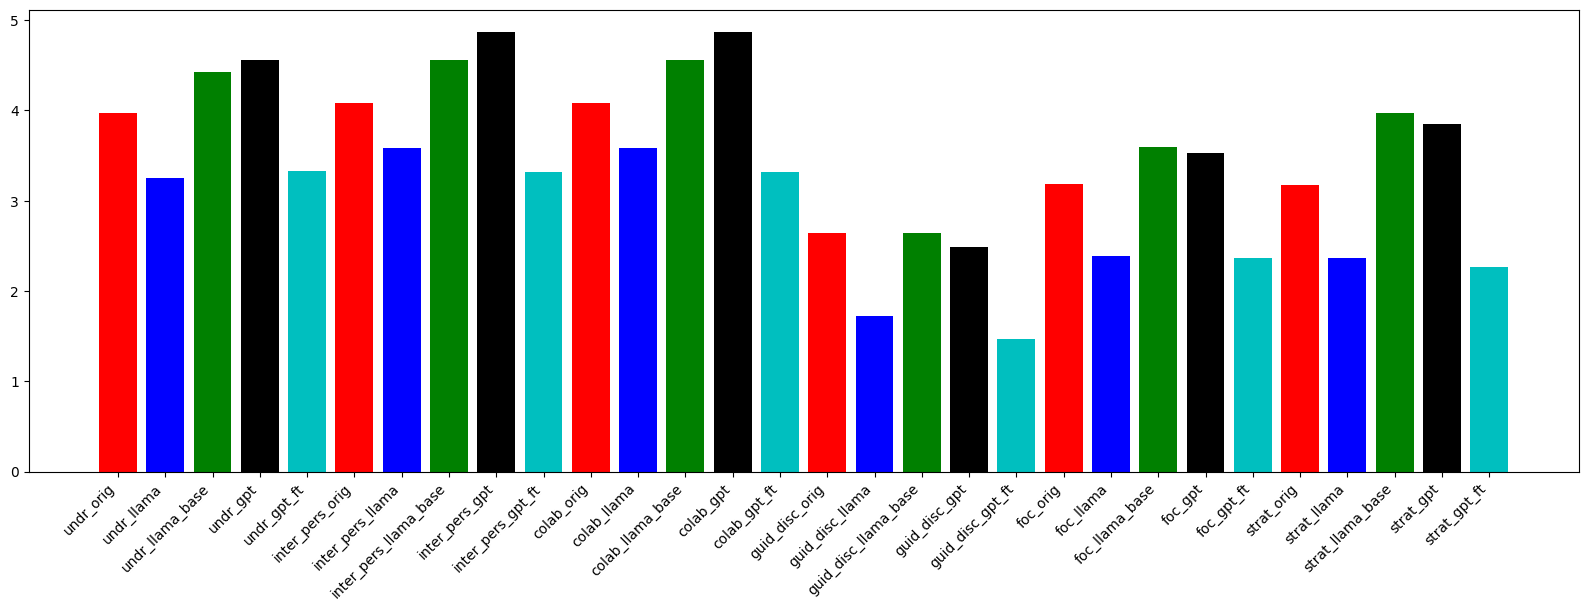

In [60]:
plt.figure(figsize=(20,6))
plt.bar(avg_metrics.index.to_list(), avg_metrics.values.tolist(), color=['r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c'])
plt.xticks(rotation=45, ha='right')
plt.show()

We can fine-tune the evaluator. Question/Answer and then we provide the rating (he issue is that A question related to Anxiety might be more popular than some other topics)

A pair-wise comparison could be better

At any time, we provide two answers (one with most votes, one with least votes). We tell them which one's better. We can use all the samples and make more pairs

For LLaMA and GPT, the length is affecting our results. So, we might want to restrict their length based on the average length of the answers in counselChat

THe bias in COunselChat could come from long answers by the evaluators or voters themselves. Maybe we can test out the length of the answers having high votes versus low votes

Print the average length of each of these